# Problem-1 Predicting the new products purchased by the customers

## 1 - Introduction
In this section, we do some preliminary tasks e.g. importing the libraries, setting the access tokens, and loading the dataset.

### 1.1 Importing necessary libraries

In [271]:
import pandas as pd
import numpy as np 
import boto3 #Accessing S3
import os #Setting the access keys
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean

### 1.2 Setting the access tokens

In [2]:
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

### 1.3 Loading the data from S3

In [3]:
# Initialize the S3 client
s3_client = boto3.client('s3')

bucket_name = 'datathon-3.0'

In [4]:
def read_csv_from_s3(bucket_name, file_key):
    try:
        obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        return pd.read_csv(obj['Body'])
    except Exception as e:
        print(f"Error reading {file_key} from bucket {bucket_name}: {e}")
        return None

We load all the tables and the customers for whom the product has to be predicted.

In [247]:
prob1Cust = read_csv_from_s3(bucket_name, 'Q1-customers.csv')
dfCust = read_csv_from_s3(bucket_name, 'TBL_CUSTOMER_PROFILE.csv')
dfDataComp = read_csv_from_s3(bucket_name, 'TBL_DATA_CONSUMPTION.csv')
dfPackPurchase = read_csv_from_s3(bucket_name, 'TBL_PACK_PURCHASE.csv')
dfPackInfo = read_csv_from_s3(bucket_name, 'TBL_PRODUCT_CATALOGUE.csv')

In [198]:
prob1Cust.head()

,CUSTOMER_ID
0,CD1F7B49575998
1,CD1F7B86F083B7
2,CD1F7C8C57DA02
3,CD1F7DA21C1ED4
4,CD1F7EBFC7032A


# 2 Knowing the Data
In this section, we try to gain insights from the loaded datasets. We try to understand the summary statistics of our dataset and try to visualize the data to gain relevant information.

## 2.1 Insights on the Packets
Since our objective is to predict the new packets, let's explore the dataset containing information of the packets.

In [202]:
dfPackInfo.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
0,1,Standard,Digital Wallets,1298,30,320.0,Discontinue
1,2,Standard,Cash,328,30,24.0,Continue
2,3,Premium,Mobile Walet,176,3,24.0,Discontinue
3,4,Premium,Cash,558,15,64.0,Discontinue
4,5,Premium,Cash,300,7,20.0,New


The dataset has more than 2k rows and 7 columns.

In [203]:
dfPackInfo.shape

(2049, 7)

Here are the list of columns and their data types. We do not have any null values.

In [205]:
dfPackInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PACK_ID         2049 non-null   int64  
 1   SERVICE_TYPE    2049 non-null   object 
 2   PAYMENT_METHOD  2049 non-null   object 
 3   PACK_PRICE      2049 non-null   int64  
 4   VALIDITY        2049 non-null   int64  
 5   DATA_VOL_GB     2049 non-null   float64
 6   PRODUCT_STATUS  2049 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 112.2+ KB


Find the value counts of all four categorical values.

### 2.1.1. Visualizing the categorical data

In [223]:
print(dfPackInfo["SERVICE_TYPE"].value_counts())
print()
print(dfPackInfo["PAYMENT_METHOD"].value_counts())
print()
print(dfPackInfo["VALIDITY"].value_counts())
print()
print(dfPackInfo["PRODUCT_STATUS"].value_counts())

SERVICE_TYPE
Premium     1285
Standard     764
Name: count, dtype: int64

PAYMENT_METHOD
Digital Wallets    622
Cash               596
Credit Card        552
Mobile Walet       279
Name: count, dtype: int64

VALIDITY
30    1136
7      565
3      218
15     130
Name: count, dtype: int64

PRODUCT_STATUS
Discontinue    1314
New             527
Continue        208
Name: count, dtype: int64


/tmp/ipykernel_41247/104110389.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=service_type_counts.index, y=service_type_counts.values, ax=axs[0, 0], palette='muted')
/tmp/ipykernel_41247/104110389.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_method_counts.index, y=payment_method_counts.values, ax=axs[0, 1], palette='muted')
/tmp/ipykernel_41247/104110389.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=validity_counts.index, y=validity_counts.values, ax=axs[1, 0], palette='muted')
/tmp/ipykernel_41247/104110389

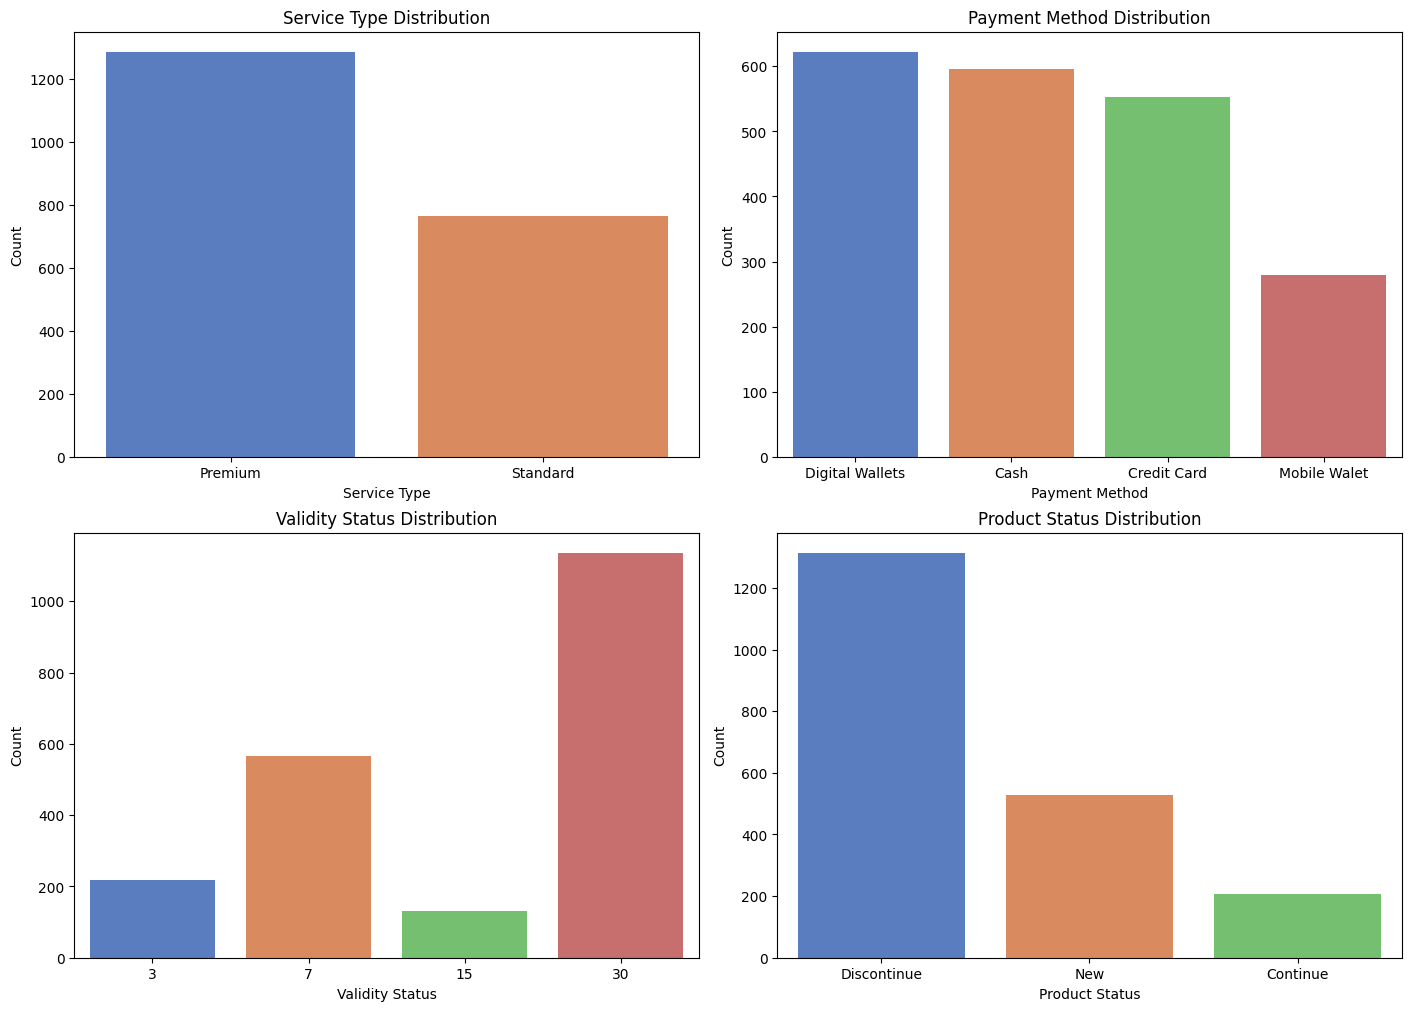

In [224]:
# Creating subplots for the value_counts of the categorical variables
fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# Plot for SERVICE_TYPE
service_type_counts = dfPackInfo['SERVICE_TYPE'].value_counts()
sns.barplot(x=service_type_counts.index, y=service_type_counts.values, ax=axs[0, 0], palette='muted')
axs[0, 0].set_title('Service Type Distribution')
axs[0, 0].set_xlabel('Service Type')
axs[0, 0].set_ylabel('Count')

# Plot for PAYMENT_METHOD
payment_method_counts = dfPackInfo['PAYMENT_METHOD'].value_counts()
sns.barplot(x=payment_method_counts.index, y=payment_method_counts.values, ax=axs[0, 1], palette='muted')
axs[0, 1].set_title('Payment Method Distribution')
axs[0, 1].set_xlabel('Payment Method')
axs[0, 1].set_ylabel('Count')

# Plot for VALIDITY
validity_counts = dfPackInfo['VALIDITY'].value_counts()
sns.barplot(x=validity_counts.index, y=validity_counts.values, ax=axs[1, 0], palette='muted')
axs[1, 0].set_title('Validity Status Distribution')
axs[1, 0].set_xlabel('Validity Status')
axs[1, 0].set_ylabel('Count')

# Plot for PRODUCT_STATUS
product_status_counts = dfPackInfo['PRODUCT_STATUS'].value_counts()
sns.barplot(x=product_status_counts.index, y=product_status_counts.values, ax=axs[1, 1], palette='muted')
axs[1, 1].set_title('Product Status Distribution')
axs[1, 1].set_xlabel('Product Status')
axs[1, 1].set_ylabel('Count')

# Display the plots
plt.show()

### 2.1.2. Visualizing the qualitative data

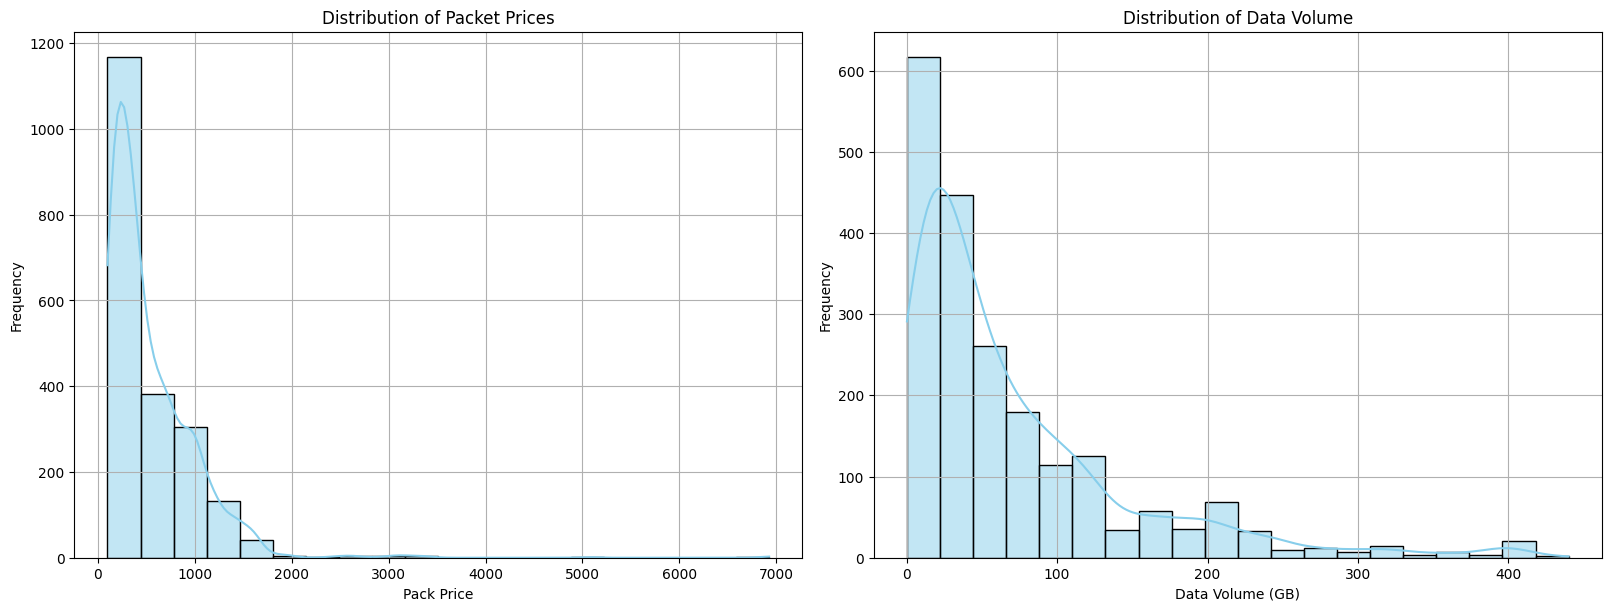

In [245]:
# Creating 2 subplots for the histograms of PACK_PRICE and DATA_VOL_GB
fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Histogram for PACK_PRICE
sns.histplot(dfPackInfo['PACK_PRICE'], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_title('Distribution of Packet Prices')
axs[0].set_xlabel('Pack Price')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Histogram for DATA_VOL_GB
sns.histplot(dfPackInfo['DATA_VOL_GB'], bins=20, kde=True, color='skyblue', ax=axs[1])
axs[1].set_title('Distribution of Data Volume')
axs[1].set_xlabel('Data Volume (GB)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Display the plots
plt.show()

### Insight-1: Our dataset has a good number of enterprise users.

### 2.1.3 EDA on New packets

In [249]:
dfPackInfoNew = dfPackInfo[dfPackInfo['PRODUCT_STATUS'] == 'New']
dfPackInfoNew.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
4,5,Premium,Cash,300,7,20.0,New
9,10,Premium,Cash,440,7,80.0,New
13,14,Standard,Credit Card,136,7,12.0,New
20,22,Standard,Mobile Walet,394,30,64.0,New
21,23,Premium,Mobile Walet,476,7,88.0,New


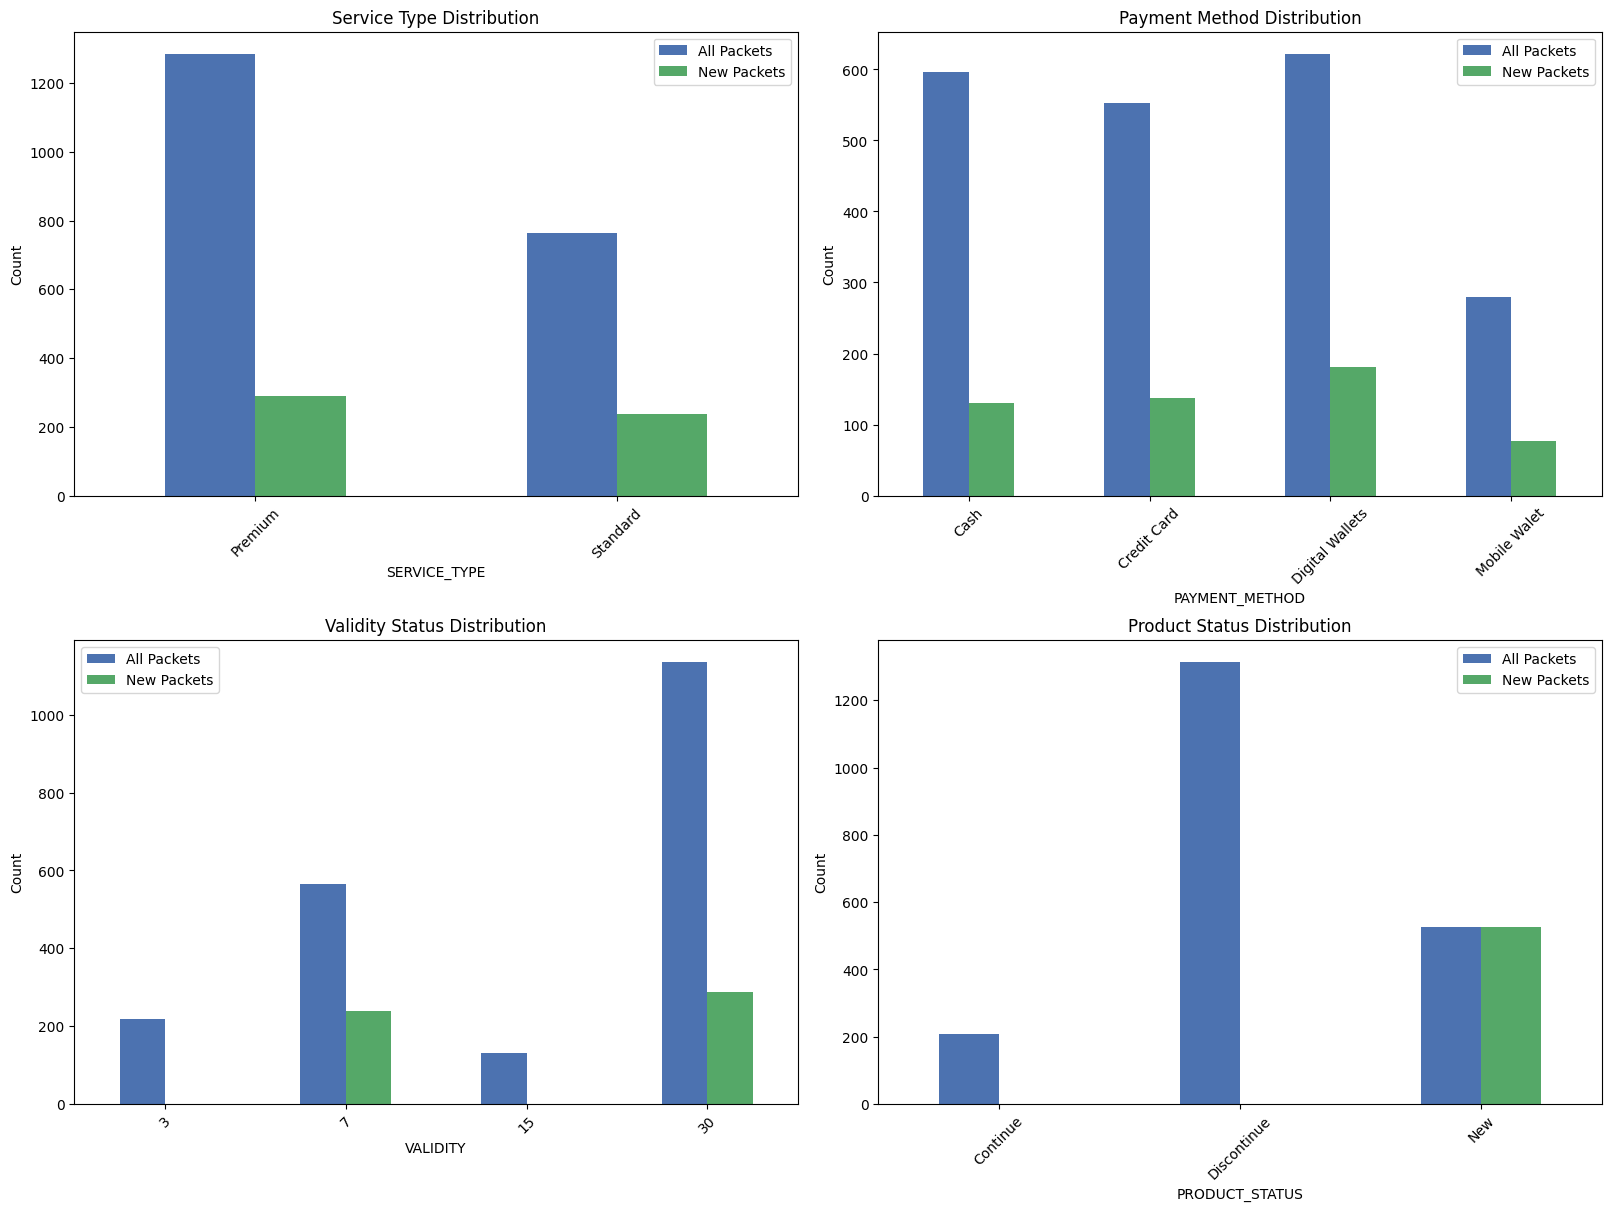

In [241]:
# Creating subplots for the categorical variables with bars side by side for both datasets
fig, axs = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Function to create side by side bar plots with updated requirements
def side_by_side_barplot(data1, data2, column, ax, title):
    count1 = data1[column].value_counts().sort_index()
    count2 = data2[column].value_counts().sort_index()
    combined = pd.DataFrame({'All Packets': count1, 'New Packets': count2}).fillna(0)
    
    combined.plot(kind='bar', ax=ax, color=['#4c72b0', '#55a868'])
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.legend(title='', labels=['All Packets', 'New Packets'])
    ax.tick_params(axis='x', rotation=45)

# SERVICE_TYPE subplot
side_by_side_barplot(dfPackInfo, dfPackInfoNew, 'SERVICE_TYPE', axs[0, 0], 'Service Type Distribution')

# PAYMENT_METHOD subplot
side_by_side_barplot(dfPackInfo, dfPackInfoNew, 'PAYMENT_METHOD', axs[0, 1], 'Payment Method Distribution')

# VALIDITY subplot
side_by_side_barplot(dfPackInfo, dfPackInfoNew, 'VALIDITY', axs[1, 0], 'Validity Status Distribution')

# PRODUCT_STATUS subplot
side_by_side_barplot(dfPackInfo, dfPackInfoNew, 'PRODUCT_STATUS', axs[1, 1], 'Product Status Distribution')

# Display the plots
plt.show()

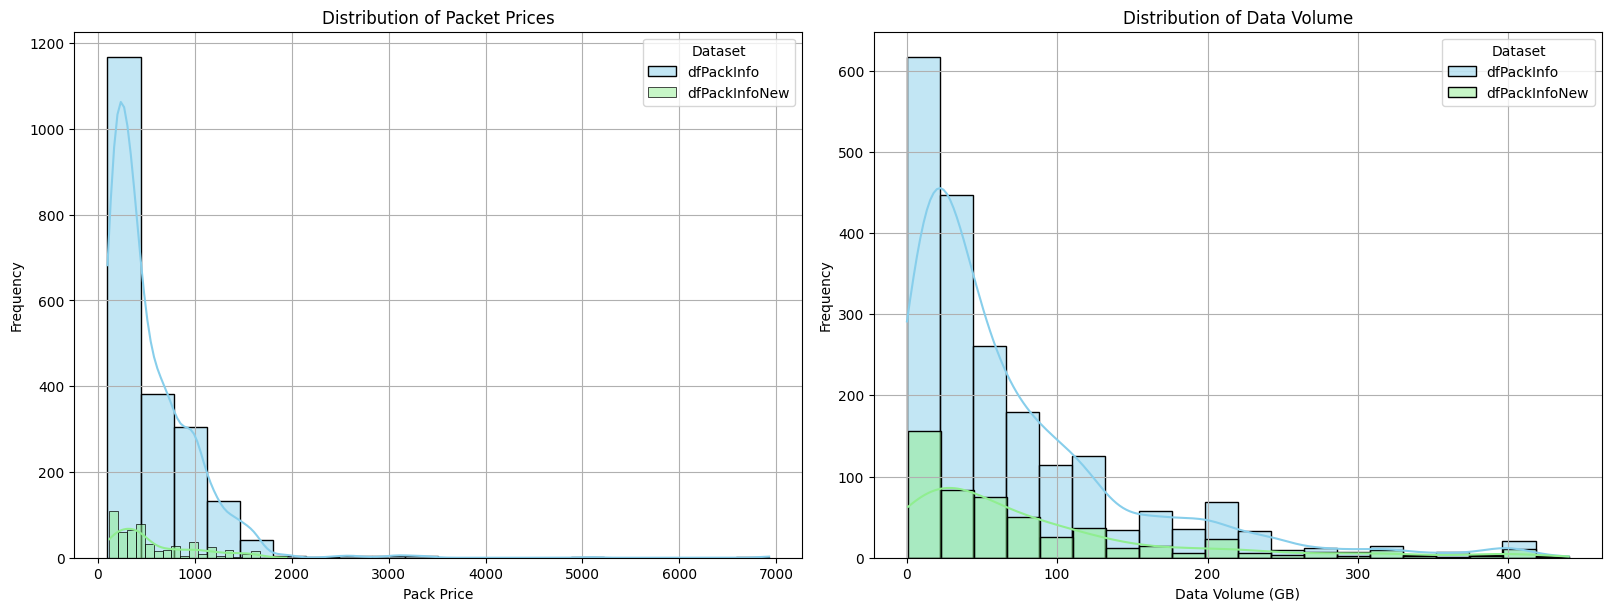

In [250]:
# Creating 2 subplots for the histograms of PACK_PRICE and DATA_VOL_GB with overlays for the new dataset
fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Histogram for PACK_PRICE
sns.histplot(dfPackInfo['PACK_PRICE'], bins=20, kde=True, color='skyblue', ax=axs[0], label='dfPackInfo')
sns.histplot(dfPackInfoNew['PACK_PRICE'], bins=20, kde=True, color='lightgreen', ax=axs[0], label='dfPackInfoNew')
axs[0].set_title('Distribution of Packet Prices')
axs[0].set_xlabel('Pack Price')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)
axs[0].legend(title='Dataset')

# Histogram for DATA_VOL_GB
sns.histplot(dfPackInfo['DATA_VOL_GB'], bins=20, kde=True, color='skyblue', ax=axs[1], label='dfPackInfo')
sns.histplot(dfPackInfoNew['DATA_VOL_GB'], bins=20, kde=True, color='lightgreen', ax=axs[1], label='dfPackInfoNew')
axs[1].set_title('Distribution of Data Volume')
axs[1].set_xlabel('Data Volume (GB)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)
axs[1].legend(title='Dataset')

# Display the plots
plt.show()

### 2.1.4 Do packets with identical properties have the same price?

In [251]:
dfPackInfo[dfPackInfo['PRODUCT_STATUS'] == 'New'].groupby(['SERVICE_TYPE', 'PAYMENT_METHOD', 'VALIDITY','DATA_VOL_GB']).size().reset_index(name='COUNT').sort_values(by='COUNT', ascending=False)

,SERVICE_TYPE,PAYMENT_METHOD,VALIDITY,DATA_VOL_GB,COUNT
20,Premium,Cash,30,4.0,10
105,Premium,Digital Wallets,7,20.0,5
275,Standard,Digital Wallets,7,32.0,4
307,Standard,Digital Wallets,30,400.0,4
267,Standard,Digital Wallets,7,12.0,4
...,...,...,...,...,...
21,Premium,Cash,30,8.0,1
25,Premium,Cash,30,32.0,1
26,Premium,Cash,30,40.0,1
29,Premium,Cash,30,100.0,1


In [253]:
dfPackInfo[dfPackInfo['PRODUCT_STATUS'] == 'New'].sort_values(by=['SERVICE_TYPE', 'PAYMENT_METHOD', 'VALIDITY', 'DATA_VOL_GB'])

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
540,543,Premium,Cash,136,7,4.0,New
2011,2022,Premium,Cash,130,7,4.0,New
212,214,Premium,Cash,160,7,6.0,New
857,861,Premium,Cash,136,7,6.0,New
250,252,Premium,Cash,180,7,8.0,New
...,...,...,...,...,...,...,...
1572,1581,Standard,Mobile Walet,994,30,220.0,New
1477,1485,Standard,Mobile Walet,1396,30,240.0,New
558,561,Standard,Mobile Walet,1396,30,280.0,New
1052,1056,Standard,Mobile Walet,1596,30,340.0,New


### Insight-2 Even if all the properties of a packet are the same, the price might vary!

## 2.2. Aggregating the Data Sources
Before proceeeding to gaining insights on the data, we must first aggregate our existing data sources. Let us identify, the sources of data that might be relevant to our analysis.

We create the dataset `dfConcern` by considering the data of the customers that are present in the test set only. We merge `prob1cust` dataframe with the purchased packets dataframe that was previously loaded.

In [ ]:
dfConcern = pd.merge(prob1Cust, dfPackPurchase, on='CUSTOMER_ID', how='left').merge(dfPackInfo, on='PACK_ID', how='left')

In [200]:
dfConcern

,CUSTOMER_ID,EVENT_DATE,PACK_ID,HITS,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
0,CD1F7B49575998,20190602,924,1,Standard,Cash,994,30,180.0,Discontinue
1,CD1F7B49575998,20190902,1893,1,Standard,Mobile Walet,994,30,180.0,Discontinue
2,CD1F7B49575998,20190803,1344,1,Standard,Mobile Walet,994,30,140.0,Discontinue
3,CD1F7B49575998,20190704,650,1,Standard,Cash,994,30,128.0,Discontinue
4,CD1F7B86F083B7,20190527,441,1,Standard,Digital Wallets,250,7,40.0,Discontinue
...,...,...,...,...,...,...,...,...,...,...
161965,CD217F99BA8816,20190930,300,1,Premium,Digital Wallets,196,3,32.0,Discontinue
161966,CD217F99BA8816,20190926,300,1,Premium,Digital Wallets,196,3,32.0,Discontinue
161967,CD2181902FB23A,20190906,2009,1,Premium,Cash,196,3,32.0,Discontinue
161968,CD2181902FB23A,20190903,565,1,Premium,Mobile Walet,196,3,32.0,Discontinue


### 2.2.1. Insights on customer of our test set

In [256]:
dfCustTest = pd.merge(prob1Cust, dfCust, on='CUSTOMER_ID', how='left')
dfCustTest.head()

,CUSTOMER_ID,SERVICE_TYPE,FIRST_CONNECTION_DATE,CONNECTION_TYPE,ROUTER_CATEGORY,STREAMING_VOL_PERCENTAGE,WEB_BROWSING_VOL_PERCENTAGE,IM_VOICE_CALL_VOL_PERCENTAGE,SNS_VOL_PERCENTAGE,FILE_ACCESS_VOL_PERCENTAGE,GAME_VOL_PERCENTAGE,NAVIGATION_VOL_PERCENTAGE,EMAIL_VOL_PERCENTAGE,OTHERS_VOL_PERCENTAGE
0,CD1F7B49575998,Standard,20230327,Cable Broadband,High End,70.9129,8.6307,7.3217,8.8879,3.9617,0.0100,0.0043,0.0000,0.2708
1,CD1F7B86F083B7,Standard,20230508,Fixed Wireless,Low End,67.7617,15.4705,3.6035,10.8574,1.0199,0.0054,0.0383,0.0000,1.2432
2,CD1F7C8C57DA02,Standard,20230320,Fixed Wireless,Low End,57.8069,21.9196,2.1142,15.5177,2.2513,0.0369,0.1074,0.0004,0.2456
3,CD1F7DA21C1ED4,Standard,20230311,Fiber Optic,Low End,49.6374,34.8527,3.6523,1.1167,7.9447,0.0077,0.0190,0.0000,2.7695
4,CD1F7EBFC7032A,Standard,20230511,Fiber Optic,High End,49.0021,22.3278,16.7901,5.9855,3.2701,0.1481,0.0043,0.0000,2.4720


/tmp/ipykernel_41247/2532658663.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='muted')
/tmp/ipykernel_41247/2532658663.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='muted')
/tmp/ipykernel_41247/2532658663.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='muted')


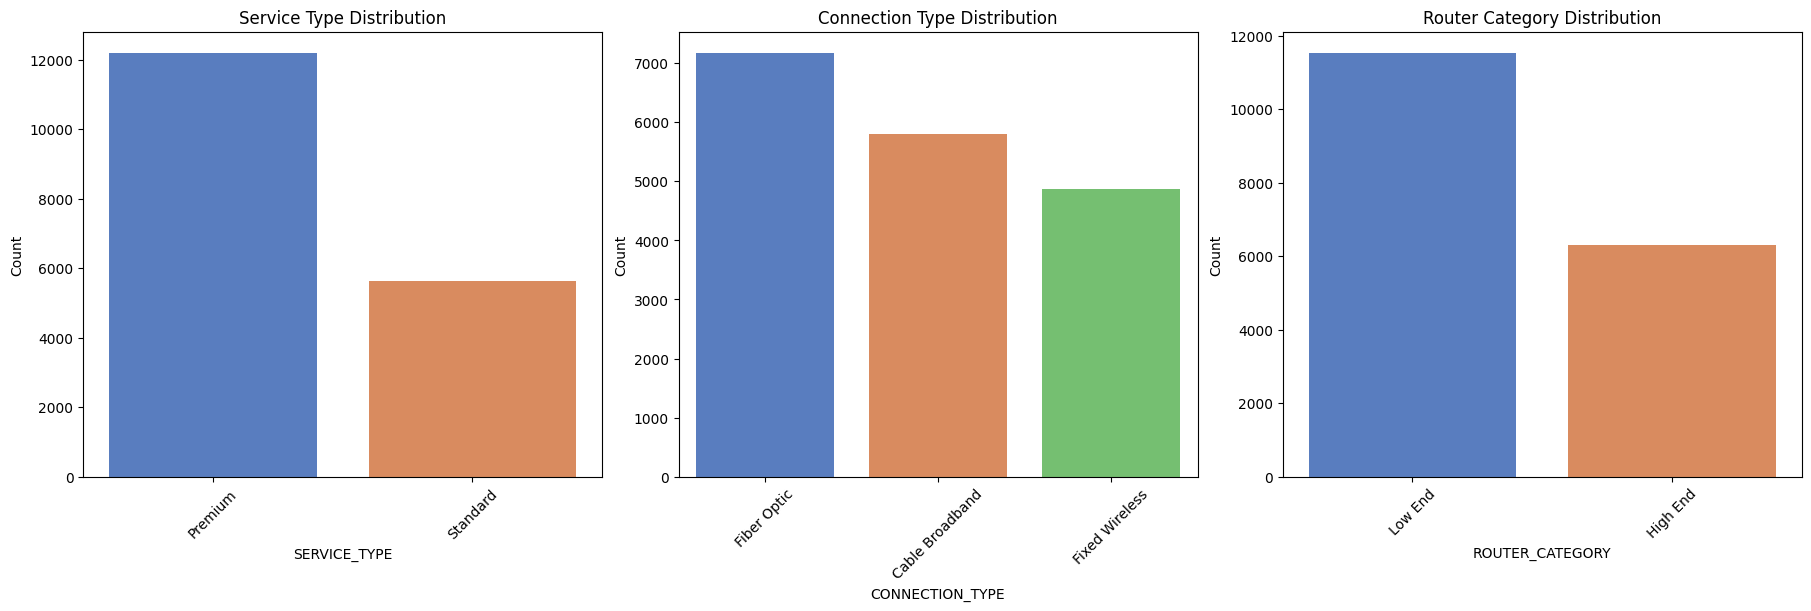

In [263]:
# Creating subplots for the value counts of the categorical variables
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Function to create a bar plot for categorical variables
def bar_plot(column, ax, title):
    value_counts = dfCustTest[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='muted')
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Plot for SERVICE_TYPE
bar_plot('SERVICE_TYPE', axs[0], 'Service Type Distribution')

# Plot for CONNECTION_TYPE
bar_plot('CONNECTION_TYPE', axs[1], 'Connection Type Distribution')

# Plot for ROUTER_CATEGORY
bar_plot('ROUTER_CATEGORY', axs[2], 'Router Category Distribution')

# Display the plots
plt.show()

### 2.2.2. Insights on the purchased packets

In [11]:
pd.merge(prob1Cust, dfPackPurchase, on='CUSTOMER_ID', how='left').merge(dfPackInfo, on='PACK_ID', how='left')['PRODUCT_STATUS'].value_counts()

PRODUCT_STATUS
Discontinue    156072
Continue         5898
Name: count, dtype: int64

### Insight-3: Majority of the previously purchased packets by the customers are discontinued!

In [12]:
dfConcern = pd.merge(prob1Cust, dfPackPurchase, on='CUSTOMER_ID', how='left').merge(dfPackInfo, on='PACK_ID', how='left')

### Insight-4: The packets exhibit similar categorical values but with varying data and price.

In [13]:
dfPackInfo[dfPackInfo['PRODUCT_STATUS'] == 'Discontinue'].sort_values(by=['SERVICE_TYPE', 'PAYMENT_METHOD', 'VALIDITY', 'DATA_VOL_GB'])

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
1682,1692,Premium,Cash,114,3,6.0,Discontinue
790,794,Premium,Cash,108,3,8.0,Discontinue
1288,1293,Premium,Cash,136,3,8.0,Discontinue
1424,1432,Premium,Cash,114,3,8.0,Discontinue
176,178,Premium,Cash,136,3,10.0,Discontinue
...,...,...,...,...,...,...,...
1882,1893,Standard,Mobile Walet,994,30,180.0,Discontinue
1727,1738,Standard,Mobile Walet,1196,30,220.0,Discontinue
875,879,Standard,Mobile Walet,1196,30,228.0,Discontinue
1810,1821,Standard,Mobile Walet,1396,30,272.0,Discontinue


### Insight-4.5 The new packets exhibit similar behaviour. But the price is often the only variable.

In [14]:
dfPackInfo[dfPackInfo['PRODUCT_STATUS'] == 'New'].sort_values(by=['SERVICE_TYPE', 'PAYMENT_METHOD', 'VALIDITY', 'DATA_VOL_GB'])

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
540,543,Premium,Cash,136,7,4.0,New
2011,2022,Premium,Cash,130,7,4.0,New
212,214,Premium,Cash,160,7,6.0,New
857,861,Premium,Cash,136,7,6.0,New
250,252,Premium,Cash,180,7,8.0,New
...,...,...,...,...,...,...,...
1572,1581,Standard,Mobile Walet,994,30,220.0,New
1477,1485,Standard,Mobile Walet,1396,30,240.0,New
558,561,Standard,Mobile Walet,1396,30,280.0,New
1052,1056,Standard,Mobile Walet,1596,30,340.0,New


# 3. Data Preprocessing

As seen previously, we do not have null values in our dataset. The IDs are unique but we can have duplicate properties of packets with the price being the only variable.

## 3.1. Data Scaling

In [16]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the columns
dfPackInfoScaled = dfPackInfo.copy()
dfPackInfoScaled[['PACK_PRICE', 'DATA_VOL_GB']] = scaler.fit_transform(dfPackInfo[['PACK_PRICE', 'DATA_VOL_GB']])

print(dfPackInfoScaled)

      PACK_ID SERVICE_TYPE   PAYMENT_METHOD  PACK_PRICE  VALIDITY  \
0           1     Standard  Digital Wallets    0.175505        30   
1           2     Standard             Cash    0.033402        30   
2           3      Premium     Mobile Walet    0.011134         3   
3           4      Premium             Cash    0.067096        15   
4           5      Premium             Cash    0.029300         7   
...       ...          ...              ...         ...       ...   
2044     2055      Premium  Digital Wallets    0.011720         7   
2045     2056     Standard  Digital Wallets    0.011427         3   
2046     2057      Premium     Mobile Walet    0.131263        30   
2047     2058      Premium             Cash    0.270730        30   
2048     2059     Standard             Cash    0.003516        30   

      DATA_VOL_GB PRODUCT_STATUS  
0        0.727149    Discontinue  
1        0.054116       Continue  
2        0.054116    Discontinue  
3        0.145066    Discontinu

## 3.2. Mapping Discontinued Product to the closest continuing/new product

In [161]:
df_discontinued = dfPackInfoScaled[dfPackInfoScaled['PRODUCT_STATUS'] == 'Discontinue']

# Initialize an empty list to store results
results = []

# Loop over each discontinued product
for index, discontinued_product in df_discontinued.iterrows():
    # Filter matching non-discontinued products
    df_matching = dfPackInfoScaled[(dfPackInfoScaled['PRODUCT_STATUS'] != 'Discontinue') &
                             (dfPackInfoScaled['SERVICE_TYPE'] == discontinued_product['SERVICE_TYPE']) &
                             (dfPackInfoScaled['PAYMENT_METHOD'] == discontinued_product['PAYMENT_METHOD']) &
                             (dfPackInfoScaled['VALIDITY'] == discontinued_product['VALIDITY'])]
    
    if df_matching.empty:
        continue

    # Calculate Euclidean distances and find the product with the minimum distance
    distances = df_matching.apply(lambda row: euclidean(discontinued_product[['PACK_PRICE', 'DATA_VOL_GB']],
                                                        row[['PACK_PRICE', 'DATA_VOL_GB']]), axis=1)
    min_distance_idx = distances.idxmin()
    mapped_product = df_matching.loc[min_distance_idx]

    # Append the result
    results.append({
        'DISCONTINUED_PRODUCT_ID': discontinued_product['PACK_ID'],
        'MAPPED_PRODUCT_ID': mapped_product['PACK_ID'],
        'MIN_DISTANCE': distances[min_distance_idx]
    })

# Create a new DataFrame with the results
df_mapped_products = pd.DataFrame(results)
df_mapped_products

MAPPED_PRODUCT_ID
1444    10
325      9
1030     9
443      9
1446     9
        ..
1512     1
159      1
1707     1
1321     1
1526     1
Name: count, Length: 426, dtype: int64

### 3.3. Merging with product IDs of the original and mapped product

In [277]:
# Joining on DISCONTINUED_PRODUCT_ID
merged_discontinued = pd.merge(df_mapped_products, dfPackInfo, left_on='DISCONTINUED_PRODUCT_ID', right_on='PACK_ID', how='inner')

# Joining on MAPPED_PRODUCT_ID
merged_mapped = pd.merge(merged_discontinued, dfPackInfo, left_on='MAPPED_PRODUCT_ID', right_on='PACK_ID', how='inner')
merged_mapped = merged_mapped.drop(columns=['VALIDITY_x', 'SERVICE_TYPE_x', 'PAYMENT_METHOD_x', 'PAYMENT_METHOD_y', 'SERVICE_TYPE_y', 'VALIDITY_y'])
merged_mapped.head()

,DISCONTINUED_PRODUCT_ID,MAPPED_PRODUCT_ID,MIN_DISTANCE,PACK_ID_x,PACK_PRICE_x,DATA_VOL_GB_x,PRODUCT_STATUS_x,PACK_ID_y,PACK_PRICE_y,DATA_VOL_GB_y,PRODUCT_STATUS_y
0,1,728,0.029593,1,1298,320.0,Discontinue,728,1500,320.0,New
1,4,198,0.139682,4,558,64.0,Discontinue,198,166,8.0,Continue
2,7,152,0.017493,7,898,44.0,Discontinue,152,796,40.0,New
3,8,243,0.000586,8,990,160.0,Discontinue,243,994,160.0,Continue
4,11,1350,0.016995,11,898,176.0,Discontinue,1350,996,180.0,New


## 3.4. Filtering within a threshold

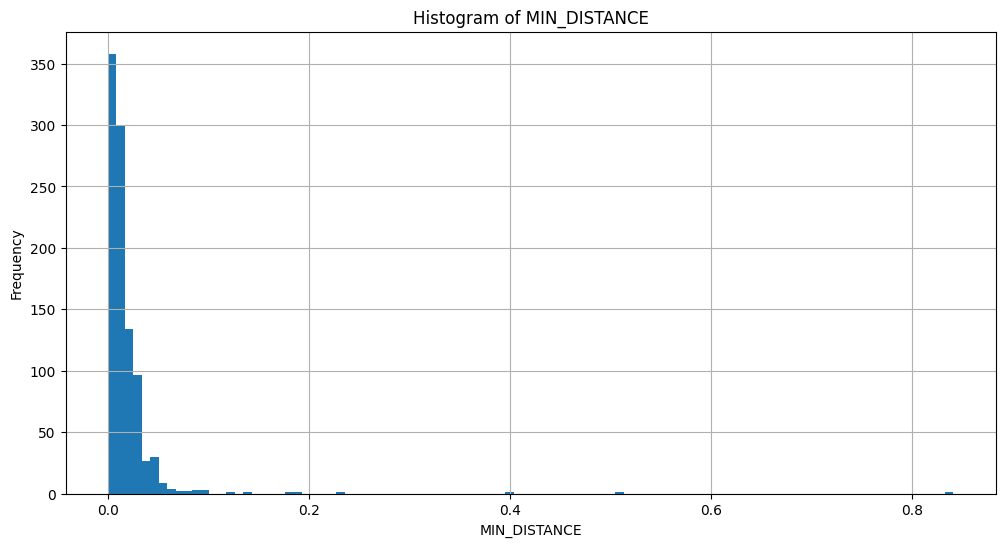

In [284]:
# Create a wider histogram with increased number of bins
filMap = pd.merge(merged_discontinued, dfPackInfo, left_on='MAPPED_PRODUCT_ID', right_on='PACK_ID', how='inner')
filMap2 = filMap[filMap['MIN_DISTANCE'] < 1]
plt.figure(figsize=(12, 6))  # Adjust the figure size to make it wider
filMap2['MIN_DISTANCE'].hist(bins=100)  # Increase the number of bins
plt.xlabel('MIN_DISTANCE')
plt.ylabel('Frequency')
plt.title('Histogram of MIN_DISTANCE')
plt.show()

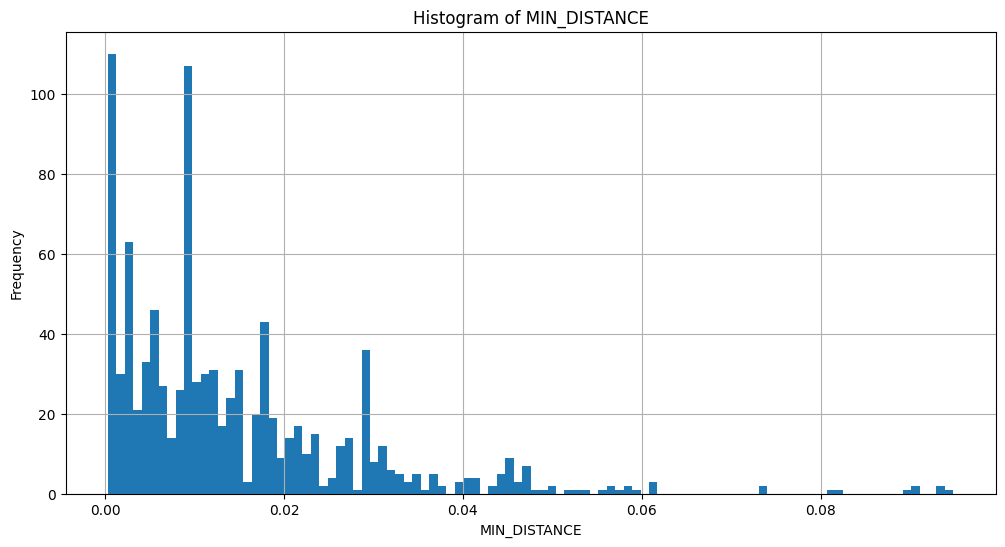

In [285]:
# Create a wider histogram with increased number of bins
filMap = pd.merge(merged_discontinued, dfPackInfo, left_on='MAPPED_PRODUCT_ID', right_on='PACK_ID', how='inner')
filMap2 = filMap[filMap['MIN_DISTANCE'] < 0.1]
plt.figure(figsize=(12, 6))  # Adjust the figure size to make it wider
filMap2['MIN_DISTANCE'].hist(bins=100)  # Increase the number of bins
plt.xlabel('MIN_DISTANCE')
plt.ylabel('Frequency')
plt.title('Histogram of MIN_DISTANCE')
plt.show()

In [286]:
filtered_merged_mapped = merged_mapped[merged_mapped['MIN_DISTANCE'] < 0.01][['DISCONTINUED_PRODUCT_ID', 'MAPPED_PRODUCT_ID']]
filtered_merged_mapped

,DISCONTINUED_PRODUCT_ID,MAPPED_PRODUCT_ID
3,8,243
5,12,856
6,16,293
7,17,1768
8,19,1030
...,...,...
970,2048,667
971,2052,1951
972,2054,195
974,2057,1312


## 3.5. Filtering the mapped products that are not new to -1

In [171]:
filtered_merged_mapped2 = filtered_merged_mapped.copy()

pack_ids = dfPackInfo[dfPackInfo['PRODUCT_STATUS'] != 'New']['PACK_ID'].tolist()
filtered_merged_mapped2.loc[filtered_merged_mapped['MAPPED_PRODUCT_ID'].isin(pack_ids), 'MAPPED_PRODUCT_ID'] = -1

In [172]:
filtered_merged_mapped2

,DISCONTINUED_PRODUCT_ID,MAPPED_PRODUCT_ID
3,8,-1
5,12,856
6,16,293
7,17,1768
8,19,-1
...,...,...
970,2048,667
971,2052,-1
972,2054,195
974,2057,-1


In [180]:
filtered_merged_mapped2['MAPPED_PRODUCT_ID'].value_counts()

MAPPED_PRODUCT_ID
-1       136
 1632      7
 325       7
 1446      6
 362       4
        ... 
 1642      1
 1358      1
 214       1
 433       1
 1045      1
Name: count, Length: 205, dtype: int64

## 3.6. An emperical example of the mapping

In [288]:
dfPackInfoScaled[dfPackInfoScaled['PACK_ID'] == 12]

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
11,12,Standard,Cash,0.086141,30,0.054116,Discontinue


In [289]:
dfPackInfoScaled[dfPackInfoScaled['PACK_ID'] == 856]

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS
852,856,Standard,Cash,0.084383,30,0.063211,New


## Assumption-1 We are storngly assuming that the customer will purchase a packet that is similar to the person's last purchase. We can also take other statistical measures like the packet with the highest mode, but emperically, we found recent purchases to be giving the best results.

## 3.7. Keeping only the latest purchases

In [79]:
dfConcern2 = dfConcern.copy()
dfConcern2['EVENT_DATE'] = pd.to_datetime(dfConcern['EVENT_DATE'], format='%Y%m%d')
dfConcern2.sort_values(by=['CUSTOMER_ID', 'EVENT_DATE'], inplace=True)
# Drop duplicates, keeping the latest entry for each CUSTOMER_ID
dfConcern2 = dfConcern2.drop_duplicates(subset=['CUSTOMER_ID'], keep='last')
dfConcern2['Y'] = -1

### 3.7.1. Sorting based on the given customer test set by performing inner join with the test set.

In [293]:
# Merge dfConcern2 with filtered_merged_mapped 
merged_df = pd.merge(dfConcern2, filtered_merged_mapped2, left_on='PACK_ID', right_on='DISCONTINUED_PRODUCT_ID', how='left')

In [183]:
dfConcern21 = pd.merge(prob1Cust, merged_df, how='inner')
dfConcern21 = dfConcern21.drop(columns=['DISCONTINUED_PRODUCT_ID'])

In [184]:
dfConcern21

,CUSTOMER_ID,EVENT_DATE,PACK_ID,HITS,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,Y,MAPPED_PRODUCT_ID
0,CD1F7B49575998,2019-09-02,1893,1,Standard,Mobile Walet,994,30,180.0,Discontinue,-1,NaN
1,CD1F7B86F083B7,2019-09-29,783,1,Standard,Mobile Walet,798,30,72.0,Discontinue,-1,NaN
2,CD1F7C8C57DA02,2019-09-26,839,1,Standard,Credit Card,400,30,40.0,Discontinue,-1,1216.0
3,CD1F7DA21C1ED4,2019-09-23,1085,1,Standard,Cash,798,30,64.0,Discontinue,-1,NaN
4,CD1F7EBFC7032A,2019-09-15,650,1,Standard,Cash,994,30,128.0,Discontinue,-1,1642.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17838,CD217BB49EA9B0,2019-09-03,1754,1,Premium,Cash,1596,30,400.0,Discontinue,-1,905.0
17839,CD217C02DFF1DD,2019-09-19,1360,1,Premium,Cash,1196,30,160.0,Discontinue,-1,1468.0
17840,CD217DC3A65246,2019-09-11,1438,1,Premium,Credit Card,698,30,28.0,Discontinue,-1,1491.0
17841,CD217F99BA8816,2019-09-30,300,1,Premium,Digital Wallets,196,3,32.0,Discontinue,-1,NaN


### 3.8. Replacing the Discontinued product values in Y label

In [185]:
dfConcern3 = dfConcern21.copy()
dfConcern3.loc[
    (dfConcern3['PRODUCT_STATUS'] == 'Discontinue') & (dfConcern3['MAPPED_PRODUCT_ID'].notna()),
    'Y'
] = dfConcern3['MAPPED_PRODUCT_ID']

### Insight: Still most of the predicted value is -1 i.e. new product will not be purchased.

In [186]:
dfConcern3['Y'].value_counts()

Y
-1       10886
 517       790
 1468      657
 1642      603
 850       536
         ...  
 992         1
 303         1
 1707        1
 1535        1
 836         1
Name: count, Length: 115, dtype: int64

### 3.9. Replacing all non-new packets by -1

In [187]:
dfNNew = dfPackInfo[dfPackInfo['PRODUCT_STATUS']!= 'New']

In [188]:
dfConcern3.loc[dfConcern3['Y'].isin(dfNNew['PACK_ID']), 'Y'] = -1

### 3.10. Creating the Submission

In [192]:
df_result = dfConcern3[['CUSTOMER_ID', 'Y']].rename(columns={'Y': 'PACK_ID'})
df_result.to_csv('dfFinal.csv', index=False)